In [1]:
!pip install tensorflow-determinism

  Preparing metadata (setup.py) ... - done
Discarding https://files.pythonhosted.org/packages/76/56/79d74f25b326d8719753172496abc524980fa67d1d98bb247021376e370a/tensorflow-determinism-0.3.0.tar.gz#sha256=563316b785614df300bbdec9b3c45a94d212761aec796cf1aafcbb2f69fdeb01 (from https://pypi.org/simple/tensorflow-determinism/): Requested tensorflow-determinism from https://files.pythonhosted.org/packages/76/56/79d74f25b326d8719753172496abc524980fa67d1d98bb247021376e370a/tensorflow-determinism-0.3.0.tar.gz#sha256=563316b785614df300bbdec9b3c45a94d212761aec796cf1aafcbb2f69fdeb01 has inconsistent version: filename has '0.3.0', but metadata has '0.4.1'
  Preparing metadata (setup.py) ... - done
Discarding https://files.pythonhosted.org/packages/9b/28/4aa0d8f183d13d3477626e931a3363651bb8e291165d58962a39c57ae7fb/tensorflow-determinism-0.2.0.tar.gz#sha256=1e364b142acd96ec8a8fca6dee32ef04e1c5f5ca20bd83fc9ec37f7dbf2fb5b5 (from https://pypi.org/simple/tensorflow-determinism/): Requested tensorflow

# Imports libraries

In [2]:
import os
import random
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
print(tf.__version__)

2.6.4


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.regularizers import L2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
SEED = 42
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
def set_global_determinism(seed):
    set_seeds(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

set_global_determinism(seed=SEED)

# Download dataset

In [6]:
train_cats = len(os.listdir("../input/cat-and-dog/training_set/training_set/cats"))
train_dogs = len(os.listdir("../input/cat-and-dog/training_set/training_set/dogs"))
print(f'The training dataset contains {train_cats} cat images and {train_dogs} dog images')

The training dataset contains 4001 cat images and 4006 dog images


In [7]:
test_cats = len(os.listdir("../input/cat-and-dog/test_set/test_set/cats"))
test_dogs = len(os.listdir("../input/cat-and-dog/test_set/test_set/dogs"))
print(f'The test dataset contains {test_cats} cat images and {test_dogs} dog images')

The test dataset contains 1012 cat images and 1013 dog images


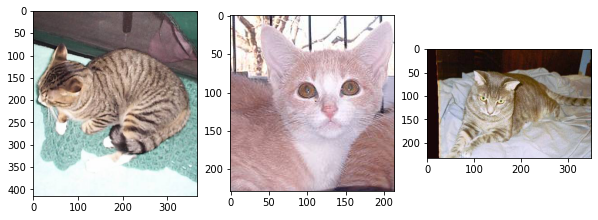

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

path = "../input/cat-and-dog/training_set/training_set/cats"
for i, ax in enumerate(axes.flat):
    files = random.choices(os.listdir(path), k=3)
    files = [path+'/'+file for file in files]
    ax.imshow(plt.imread(files[i]))

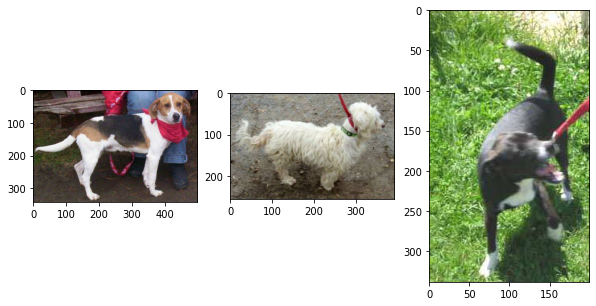

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

path = "../input/cat-and-dog/training_set/training_set/dogs"
for i, ax in enumerate(axes.flat):
    files = random.choices(os.listdir(path), k=3)
    files = [path+'/'+file for file in files]
    ax.imshow(plt.imread(files[i]))

## Create a dataset

In [10]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory="../input/cat-and-dog/training_set/training_set",
    label_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    seed=SEED,
    validation_split=0.15,
    subset='training'
)

Found 8005 files belonging to 2 classes.
Using 6805 files for training.


2022-11-12 02:27:30.394415: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 02:27:30.531154: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 02:27:30.532127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 02:27:30.535988: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
valid_ds = tf.keras.utils.image_dataset_from_directory(
    directory="../input/cat-and-dog/training_set/training_set",
    label_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    seed=SEED,
    validation_split=0.15,
    subset='validation'
)

Found 8005 files belonging to 2 classes.
Using 1200 files for validation.


In [13]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory="../input/cat-and-dog/test_set/test_set",
    label_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    seed=SEED,
)

Found 2023 files belonging to 2 classes.


In [14]:
class_names = train_ds.class_names
class_names

['cats', 'dogs']

2022-11-12 02:27:34.406062: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


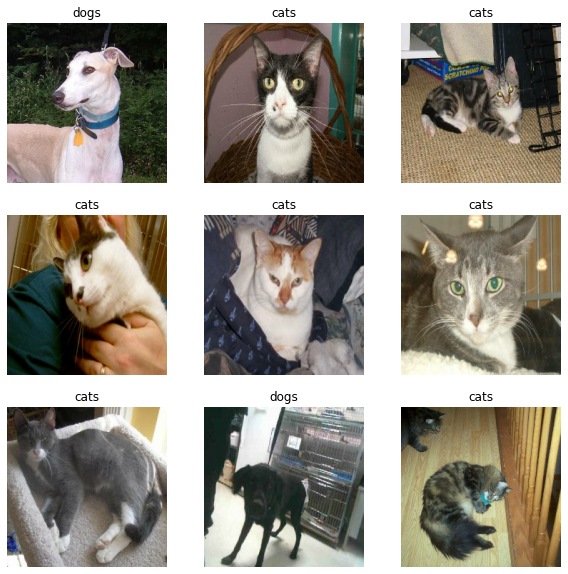

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy()[1].astype("uint8")])
        plt.axis("off")

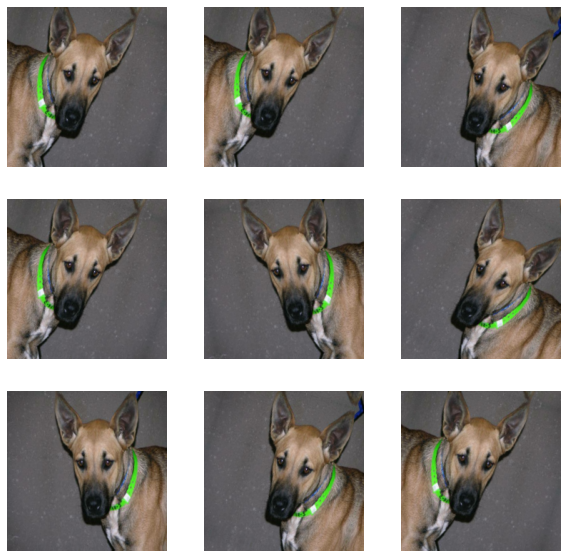

In [16]:
data_augmentation = Sequential([
    RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    RandomRotation(0.1)
])

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Transfer learning with VGG16

## Method 1 - Feature Extraction

When `include_top = False`, the top layers (layers from flatten layers) will not be included. Because imagenet has 1000 classes and our use case is predicting 2 classes. So, we will have to exclude top layers from the pre-trained model and add our own.

In [17]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [18]:
base_model.trainable = False
# base_model.summary()

In [19]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.categorical_accuracy]
)

In [21]:
EPOCHS = 5
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    batch_size=32,
    epochs=EPOCHS
)

Epoch 1/5


2022-11-12 02:27:43.479030: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


213/213 [==============================] - 45s 167ms/step - loss: 0.1125 - categorical_accuracy: 0.9562 - val_loss: 0.0369 - val_categorical_accuracy: 0.9842
Epoch 2/5
213/213 [==============================] - 14s 66ms/step - loss: 0.0607 - categorical_accuracy: 0.9774 - val_loss: 0.0296 - val_categorical_accuracy: 0.9875
Epoch 3/5
213/213 [==============================] - 14s 65ms/step - loss: 0.0544 - categorical_accuracy: 0.9813 - val_loss: 0.0300 - val_categorical_accuracy: 0.9867
Epoch 4/5
213/213 [==============================] - 15s 67ms/step - loss: 0.0491 - categorical_accuracy: 0.9813 - val_loss: 0.0290 - val_categorical_accuracy: 0.9883
Epoch 5/5
213/213 [==============================] - 15s 70ms/step - loss: 0.0444 - categorical_accuracy: 0.9828 - val_loss: 0.0226 - val_categorical_accuracy: 0.9917


In [22]:
df = pd.DataFrame(history.history)
df

,loss,categorical_accuracy,val_loss,val_categorical_accuracy
0,0.112473,0.956209,0.036880,0.984167
1,0.060671,0.977370,0.029620,0.987500
2,0.054444,0.981337,0.029994,0.986667
3,0.049051,0.981337,0.029016,0.988333
4,0.044360,0.982807,0.022616,0.991667


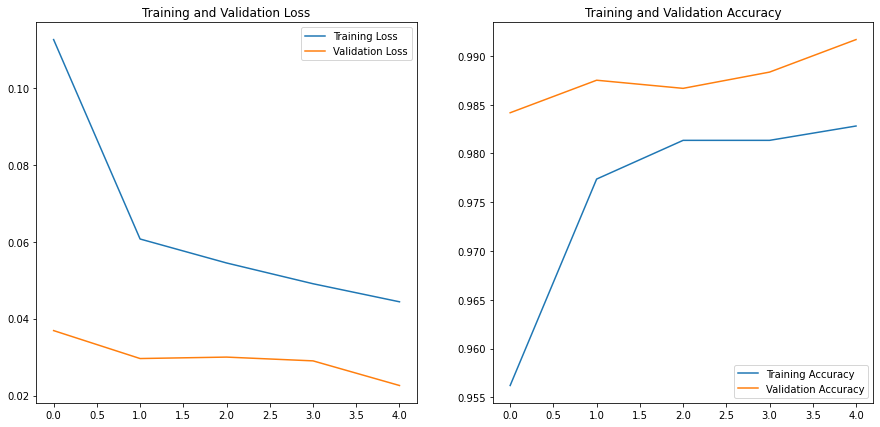

<Figure size 720x432 with 0 Axes>

In [23]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.figure(figsize=(10, 6));

In [24]:
model.evaluate(test_ds, batch_size=32, verbose=1)

64/64 [==============================] - 9s 123ms/step - loss: 0.0362 - categorical_accuracy: 0.9871


[0.036206528544425964, 0.9871478080749512]

## Method 2 - Fine-tuning

In [25]:
base_model.trainable = True

In [26]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [27]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [28]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [29]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.categorical_accuracy]
)

In [30]:
EPOCHS = 5
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    batch_size=32,
    epochs=EPOCHS
)

Epoch 1/5
213/213 [==============================] - 21s 80ms/step - loss: 0.1158 - categorical_accuracy: 0.9540 - val_loss: 0.0413 - val_categorical_accuracy: 0.9833
Epoch 2/5
213/213 [==============================] - 15s 70ms/step - loss: 0.0459 - categorical_accuracy: 0.9822 - val_loss: 0.0239 - val_categorical_accuracy: 0.9900
Epoch 3/5
213/213 [==============================] - 16s 71ms/step - loss: 0.0439 - categorical_accuracy: 0.9825 - val_loss: 0.0210 - val_categorical_accuracy: 0.9917
Epoch 4/5
213/213 [==============================] - 16s 71ms/step - loss: 0.0368 - categorical_accuracy: 0.9869 - val_loss: 0.0334 - val_categorical_accuracy: 0.9892
Epoch 5/5
213/213 [==============================] - 15s 70ms/step - loss: 0.0282 - categorical_accuracy: 0.9896 - val_loss: 0.0161 - val_categorical_accuracy: 0.9925


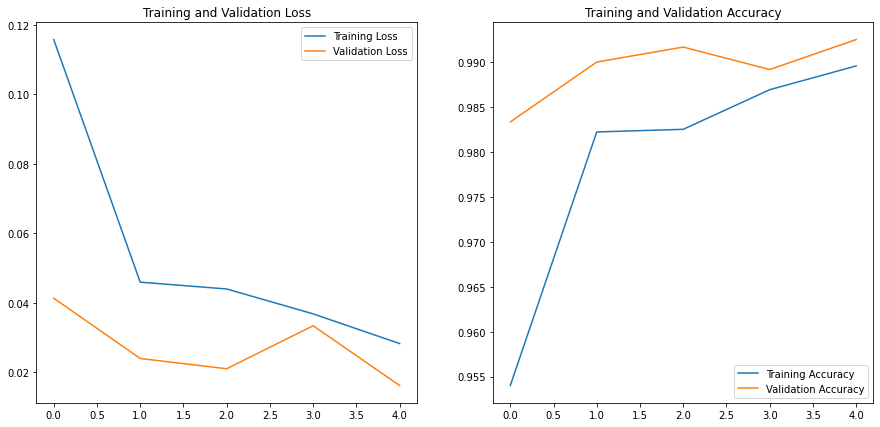

<Figure size 720x432 with 0 Axes>

In [31]:
df = pd.DataFrame(history.history)

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.figure(figsize=(10, 6));